# 多項式曲線フィッティング


"IPython Interactive Computing and Visualization Cookbook" (O'Reilly, 2014)のサンプルプログラム8.1を例に


## 2乗誤差最小化

説明変数$x$に対する目的変数$y$について、$M$次関数でのフィッティングを考える：
$$
 y(x, {\bf w}) = w_0 + w_1 x + w_2 x^2 + \cdots + w_M x^M = \sum_{j=0}^{M} w_j x^j
$$
データ$\{(x_n, t_n)\}$ ($n=1,\cdots N$)があったときに、
2乗誤差
$$
E({\bf w}) = \frac{1}{2} \sum_{n=1}^N \{y(x_n,{\bf w}) - t_n\}^2
$$
を最小にするよう${\bf w}$を決める。



上記のプログラム例で、テストデータやフィッティング関数のべき次数をあげて試してみてほしいが、もう少し実感がわく事例としてPRMLに載っている図を載せておく。

最小２乗法の模式図：

<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.3.png" width="400">


$\sin$カーブにノイズを載せたテストデータをべき関数フィッティングしてみた例：次数をあげれば全データにあうフィッティングができるが、不自然であることがわかるだろう。($M$が次数)
<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.4a.png" width="400">
<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.4b.png" width="400">
<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.4c.png" width="400">
<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.4d.png" width="400">



### pythonスクリプトでの実例

In [2]:
import numpy as np
import scipy.stats as st
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
f = lambda x: np.exp(3*x)

In [4]:
# [0,2]の値生成 (トレーニングデータ用のベースとする関数描画用)
x_tr = np.linspace(0., 2., 200)
y_tr = f(x_tr)

In [5]:
# [0, 1.0の間でデータ点を生成、関数ｆの値にガウスノイズを乗せる
x = np.array([0, .1, .2, .5, .8, .9, 1.])
y = f(x) + np.random.randn(len(x))

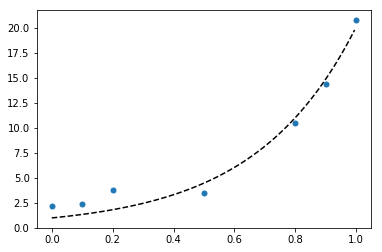

In [6]:
#[0,1.]で生成したデータを描画
plt.plot(x_tr[:100], y_tr[:100], '--k')
plt.plot(x, y, '.', ms=10)

### 線形近似

$$y = w_0 + w_1 x$$として$w_0$, $w_1$を学習データより決める。

In [7]:
# scikit-learnの線形モデル
lr = lm.LinearRegression()
# 訓練データセットによる訓練
lr.fit(x[:, np.newaxis], y)
# 予測
y_lr = lr.predict(x_tr[:, np.newaxis]) # np.newaxisにより行ベクトルを列ベクトルに変換
# print(x)
# print(x[:,np.newaxis])

Text(0.5,1,'Linear Regression')

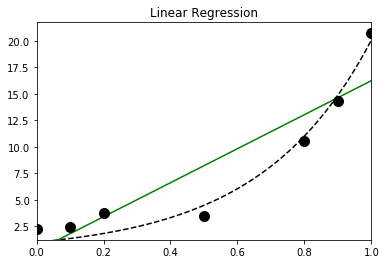

In [8]:
# プロット
plt.plot(x_tr, y_tr, '--k')
plt.plot(x_tr, y_lr, 'g')
plt.plot(x, y, 'ok', ms=10)
plt.xlim(0,1)
plt.ylim(y.min()-1, y.max()+1)
plt.title("Linear Regression")

### べき乗関数へのフィッティング

あらかじめ次数$M$を決めて、係数を学習により決める。

プログラムでは、あるベクトルに対し、指定したべきの値を１列に出力する関数np.vanderを用いている。

結果からわかるように、データ点がある範囲では高次の関数で近似したほうがよくあてはまるが、範囲外には適用できない可能性がある。（過学習）

print文で出力された係数を見ると、高次の係数が非常に大きな値になっていることがわかる。

（注）np.vanderは、１次元配列と次数を与えるて、各次数のべき乗の値を各列とした行列を出力する関数


30.15  -14.09  0.00
643.99  -1285.97  87.05  1406.08  -1105.75  290.36  -17.24  0.00


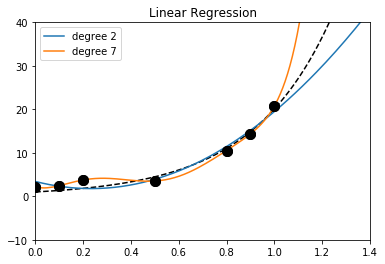

In [11]:
lrp = lm.LinearRegression()
plt.plot(x_tr, y_tr, '--k')
for deg in [2,7]:
    lrp.fit(np.vander(x, deg +1), y)
    y_lrp = lrp.predict(np.vander(x_tr, deg+1))
    plt.plot(x_tr, y_lrp,
            label='degree ' + str(deg))
    plt.legend(loc=2)
    plt.xlim(0, 1.4)
    plt.ylim(-10, 40)
    # モデルの係数表示
    print('  '. join(['%.2f' % c for c in lrp.coef_]))
    plt.plot(x, y , 'ok', ms=10)
    plt.title('Linear Regression')

## リッジ回帰

過学習を防ぐために、次のような係数に対する2次関数を付加し、その最小化を図る。この項は大きな係数の方が不利になるので、高次の項の「暴発」が抑えられる。

$$
\tilde{E}({\bf w}) = \frac{1}{2} \sum_{n=1}^N \{y(x_n,{\bf w}) - t_n\}^2 + \frac{\lambda}{2}||{\bf w}||^2
$$

これはリッジ回帰(ridge regression)を呼ばれる。ニューラルネットでは、過重減衰(weight decay)として知られている。

ちなみに、ウェイトの項を単に絶対値$\frac{\lambda}{2}||{\bf w}||$にしたものをlasso回帰と呼ぶ。

### リッジ回帰説明

上記のPRMLの事例にある式で係数$\lambda$を固定して最小化を行った例($M=9$)：$\lambda$が大きいと係数が小さくなりすぎる。リッジ回帰では誤差が小さくなるよう$\lambda$を決める。

<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.7a.png" width="400">
<img src="http://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/prmlfigs-png/Figure1.7b.png" width="400">

### pythonスクリプトでの実例

6.15  4.96  0.00
3.24  3.21  3.11  2.88  2.35  0.00
1.33  1.39  1.47  1.56  1.65  1.76  1.87  1.96  1.99  1.85  0.00


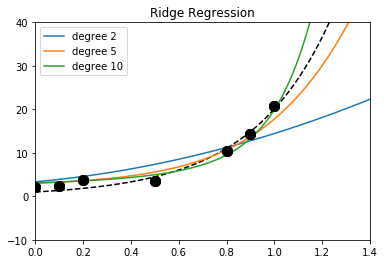

In [10]:
ridge = lm.Ridge()
plt.plot(x_tr, y_tr, '--k')
for deg in [2,5,10]:
    ridge.fit(np.vander(x, deg +1), y)
    y_ridge = ridge.predict(np.vander(x_tr, deg+1))
    plt.plot(x_tr, y_ridge,
            label='degree ' + str(deg))
    plt.legend(loc=2)
    plt.xlim(0, 1.4)
    plt.ylim(-10, 40)
    # モデルの係数表示
    print('  '. join(['%.2f' % c for c in ridge.coef_]))
    plt.plot(x, y , 'ok', ms=10)
    plt.title('Ridge Regression')

# ベイズ的予測への発展

上での回帰線は、最も尤もらしい（もっともらしい）線を描いた。しかし、最適な曲線が真の値（曲線）とは言えない。最も尤もらしいにすぎない。どのくらい尤もらしいかの幅があるはずである。幅、つまり考えられる曲線を表す係数${\bf w}$あるいは推定値$y$は最も尤もらしい値を平均とする確率分布として与えられる。


参考： https://qiita.com/ctgk/items/555802600638f41b40c5
（このページの最後の図を参照してほしい。ただし、色付けされた予測分布の標準偏差幅の導出に使っている式の根拠はPRMLの第３章を読まないとわからないことに注意）
